In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt

from Airfoils import airfoil as af

from Software.Foil2Wake import runF2w as f2w
from Software.OpenFoam import runOpenFoam as of
from Software.Xfoil import runXFoil as xf
from Database import BASEFOIL2W , BASEOPENFOAM, DB2D

In [3]:
HOMEDIR = os.getcwd()

# Reynolds And Mach and AoA

In [4]:
def ms2mach(ms):
    return ms / 340.29

def Re(v, c, n):
    return (v * c) / n

In [5]:
chordMax = 0.18
chordMin = 0.11
umax = 30
umin = 5
ne = 1.56e-5

In [6]:
Machmin = ms2mach(10)
Machmax = ms2mach(30)
Remax = Re(umax, chordMax, ne)
Remin = Re(umin, chordMin, ne)
AoAmax = 15
AoAmin = -6
NoAoA = (AoAmax - AoAmin) * 2 + 1

angles = np.linspace(AoAmin, AoAmax, NoAoA)
Reynolds = np.logspace(np.log10(Remin), np.log10(Remax), 20, base=10)
Mach = np.linspace(Machmax, Machmin, 10)

Reyn = Reynolds[1]
MACH = Machmax
print(f"Nominal: Mach {MACH}\tReynolds {Reyn}")

Nominal: Mach 0.08816009873931058	Reynolds 39760.35494495576


In [7]:
cleaning = False
calcF2W = True
calcOpenFoam = False
calcXFoil = True

# Get Airfoil

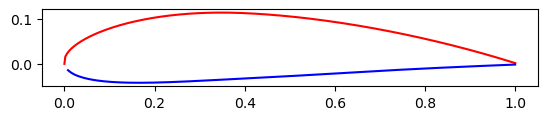

In [8]:
airf = af.AirfoilData.NACA('4415',n_points=200)
airf.initDB(HOMEDIR,DB2D)
airf.plotAirfoil()

# Foil2Wake

In [9]:
ftrip_low = {"pos": 0.1, "neg": 0.2}
ftrip_up = {"pos": 0.2, "neg": 0.1}
Ncrit = 9
airf.reynCASE(Reyn)

if cleaning == True:
    airf.cleanRes(f2w.removeResults, [airf.REYNDIR, airf.HOMEDIR,angles])
if calcF2W == True:
    f2wargs = [airf.REYNDIR,airf.HOMEDIR,Reyn, MACH, ftrip_low, ftrip_up, angles, f"naca{airf.name}"]
    airf.setupSolver(f2w.setupF2W,[BASEFOIL2W,airf.HOMEDIR,airf.REYNDIR])
    airf.runSolver(f2w.runF2W,f2wargs)

Running [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0]


mkdir: cannot create directory ‘0.00000/’: File exists
mkdir: cannot create directory ‘0.50000/’: File exists
mkdir: cannot create directory ‘1.00000/’: File exists
mkdir: cannot create directory ‘1.50000/’: File exists
mkdir: cannot create directory ‘2.00000/’: File exists
mkdir: cannot create directory ‘2.50000/’: File exists
mkdir: cannot create directory ‘3.00000/’: File exists
mkdir: cannot create directory ‘3.50000/’: File exists
mkdir: cannot create directory ‘4.00000/’: File exists
mkdir: cannot create directory ‘4.50000/’: File exists
mkdir: cannot create directory ‘5.00000/’: File exists
mkdir: cannot create directory ‘5.50000/’: File exists
mkdir: cannot create directory ‘6.00000/’: File exists
mkdir: cannot create directory ‘6.50000/’: File exists
rm: cannot remove 'TMP.dir/': No such file or directory
mkdir: cannot create directory ‘m0.0000/’: File exists


Running [0.0, -0.5, -1.0, -1.5, -2.0, -2.5, -3.0, -3.5, -4.0, -4.5, -5.0, -5.5, -6.0]


rm: cannot remove 'TMP.dir/': No such file or directory


In [10]:
airf.makePolars(f2w.makeCLCD,[airf.REYNDIR, airf.HOMEDIR,Reyn, MACH])

Making Polars


# Xfoil

In [11]:
airf.selig.T

array([[ 1.        ,  0.00156086],
       [ 0.99508935,  0.00309901],
       [ 0.99017608,  0.00462642],
       [ 0.98526021,  0.00614314],
       [ 0.98034178,  0.00764922],
       [ 0.9754208 ,  0.00914471],
       [ 0.97049729,  0.01062965],
       [ 0.96557128,  0.0121041 ],
       [ 0.96064279,  0.0135681 ],
       [ 0.95571184,  0.01502169],
       [ 0.95077845,  0.01646491],
       [ 0.94584265,  0.01789781],
       [ 0.94090445,  0.01932042],
       [ 0.93596387,  0.02073279],
       [ 0.93102094,  0.02213494],
       [ 0.92607567,  0.02352693],
       [ 0.92112808,  0.02490877],
       [ 0.91617819,  0.02628052],
       [ 0.91122603,  0.02764219],
       [ 0.9062716 ,  0.02899381],
       [ 0.90131493,  0.03033543],
       [ 0.89635604,  0.03166706],
       [ 0.89139494,  0.03298874],
       [ 0.88643165,  0.03430049],
       [ 0.88146618,  0.03560233],
       [ 0.87649856,  0.03689429],
       [ 0.8715288 ,  0.03817638],
       [ 0.86655692,  0.03944864],
       [ 0.86158293,

In [12]:
clcdcmXF = xf.runXFoil(Reyn, MACH,min(angles),max(angles),0.5,airf.selig.T)
formatting_function = np.vectorize(lambda f: format(f, '6.3E'))
print(formatting_function(clcdcmXF))

[['-6.000E+00' '-2.775E-01' '3.439E-02' '-8.085E-02']
 ['-5.500E+00' '-2.323E-01' '3.303E-02' '-7.956E-02']
 ['-5.000E+00' '-1.855E-01' '3.201E-02' '-7.845E-02']
 ['-4.500E+00' '-1.378E-01' '3.124E-02' '-7.742E-02']
 ['-4.000E+00' '-9.067E-02' '3.067E-02' '-7.620E-02']
 ['-3.500E+00' '-4.312E-02' '3.025E-02' '-7.502E-02']
 ['-3.000E+00' '4.713E-03' '2.994E-02' '-7.383E-02']
 ['-2.500E+00' '5.255E-02' '2.975E-02' '-7.265E-02']
 ['-2.000E+00' '1.003E-01' '2.966E-02' '-7.148E-02']
 ['-1.500E+00' '1.480E-01' '2.965E-02' '-7.030E-02']
 ['-1.000E+00' '1.954E-01' '2.973E-02' '-6.910E-02']
 ['-5.000E-01' '2.426E-01' '2.988E-02' '-6.789E-02']
 ['0.000E+00' '2.894E-01' '3.012E-02' '-6.667E-02']
 ['5.000E-01' '3.358E-01' '3.043E-02' '-6.542E-02']
 ['1.000E+00' '3.815E-01' '3.082E-02' '-6.411E-02']
 ['1.500E+00' '4.265E-01' '3.128E-02' '-6.274E-02']
 ['2.000E+00' '4.703E-01' '3.183E-02' '-6.125E-02']
 ['2.500E+00' '5.124E-01' '3.244E-02' '-5.954E-02']
 ['3.000E+00' '5.534E-01' '3.316E-02' '-5.776E

In [13]:
airf.REYNDIR

'/home/titos/Desktop/AircraftAnalysis/Database/2D/NACA4415/Reynolds_3.976e04'

In [15]:
if calcXFoil == True:
    xfargs =[airf.REYNDIR,HOMEDIR,Reyn, MACH,min(angles),max(angles),0.5,airf.selig.T]
    XRES = airf.makePolars(xf.runAndSave,xfargs)


# OpenFoam

In [ ]:
os.chdir(caseDir)
maxITER = 10500
if cleaning == True:
    # of.cleanOpenFoam()
    pass
if calcOpenFoam == True:
    of.makeMesh(airfile)
    of.setupOpenFoam(Reyn, MACH, angles, silent=True, maxITER=maxITER)
    of.runFoam(angles)
clcdcmOF = of.makeCLCD(angles)